In [1]:
import numpy as np
import pandas as pd
from numpy import array
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

from pyspark.sql.functions import col


In [2]:
spark.version
sqlContext = SQLContext(sc)
batting=sqlContext.read.csv("/home/anup/bdProject/bd/stats_batting_2.csv", header=True, mode="DROPMALFORMED")
bowling=sqlContext.read.csv("/home/anup/bdProject/bd/stats_bowling_1 .csv", header=True, mode="DROPMALFORMED")
bowling.show()
batting.show()

+---------------+-------------+-------------+------------+---------------+------------+-------------------+
|    player_name|runs_conceded|wickets_taken|overs_bowled|bowling_average|economy_rate|bowling_strike_rate|
+---------------+-------------+-------------+------------+---------------+------------+-------------------+
| A Ashish Reddy|          396|           18|        43.4|             22|        9.12|              14.47|
|     A Chandila|          242|           11|          39|             22|        6.21|              21.27|
|    A Choudhary|          144|            5|        16.5|           28.8|        8.73|               19.8|
|    A Dananjaya|           47|            0|           4|           null|       11.75|               null|
|     A Flintoff|          105|            2|          11|           52.5|        9.55|                 33|
|       A Kumble|         1058|           45|       160.5|          23.51|        6.59|               21.4|
|       A Mishra|         35

In [3]:
batting.na.drop()
bowling=bowling.na.drop()

FEATURES_COL=["runs_scored","balls_faced","times_out","batting_average","strike_rate"]
FEATURES_COL_BOWL=["runs_conceded","wickets_taken","overs_bowled","bowling_average","economy_rate","bowling_strike_rate"]

# df_feat = batting.select(*(batting[c].cast("float").alias(c) for c in batting.columns[1:]))
# df_feat_bowl = bowling.select(*(bowling[c].cast("float").alias(c) for c in bowling.columns[1:]))

# df_feat_bowl.show()
# df_feat.show()

In [4]:
for col in batting.columns:
    if col in FEATURES_COL:
        batting = batting.withColumn(col,batting[col].cast('float'))
batting.show()

for col in bowling.columns:
    if col in FEATURES_COL_BOWL:
        bowling = bowling.withColumn(col,bowling[col].cast('float'))
bowling.show()

+---------------+-----------+-----------+---------+---------------+-----------+
|    player_name|runs_scored|balls_faced|times_out|batting_average|strike_rate|
+---------------+-----------+-----------+---------+---------------+-----------+
| A Ashish Reddy|      280.0|      193.0|     15.0|          18.67|     145.08|
|       A Chopra|       53.0|       71.0|      6.0|           8.83|      74.65|
|    A Choudhary|       25.0|       20.0|      1.0|           25.0|      125.0|
|     A Flintoff|       62.0|       53.0|      2.0|           31.0|     116.98|
|       A Kumble|       35.0|       47.0|      3.0|          11.67|      74.47|
|       A Mishra|      341.0|      365.0|     29.0|          11.76|      93.42|
|       A Mithun|       34.0|       26.0|      5.0|            6.8|     130.77|
|       A Mukund|       19.0|       22.0|      2.0|            9.5|      86.36|
|        A Nehra|       41.0|       62.0|      7.0|           5.86|      66.13|
|        A Singh|        2.0|       10.0

In [5]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(batting).select('player_name', 'features')
df_kmeans.show()

vecAssembler_bowl = VectorAssembler(inputCols=FEATURES_COL_BOWL, outputCol="features_bowl")
df_kmeans_bowl = vecAssembler_bowl.transform(bowling).select('player_name', 'features_bowl')
df_kmeans_bowl.show()


+---------------+--------------------+
|    player_name|            features|
+---------------+--------------------+
| A Ashish Reddy|[280.0,193.0,15.0...|
|       A Chopra|[53.0,71.0,6.0,8....|
|    A Choudhary|[25.0,20.0,1.0,25...|
|     A Flintoff|[62.0,53.0,2.0,31...|
|       A Kumble|[35.0,47.0,3.0,11...|
|       A Mishra|[341.0,365.0,29.0...|
|       A Mithun|[34.0,26.0,5.0,6....|
|       A Mukund|[19.0,22.0,2.0,9....|
|        A Nehra|[41.0,62.0,7.0,5....|
|        A Singh|[2.0,10.0,4.0,0.5...|
|      A Symonds|[974.0,750.0,27.0...|
|       A Uniyal|[4.0,7.0,1.0,4.0,...|
|        A Zampa|[5.0,8.0,2.0,2.5,...|
|    AA Bilakhia|[69.0,85.0,5.0,13...|
|      AA Chavan|[12.0,11.0,2.0,6....|
|AA Jhunjhunwala|[217.0,210.0,13.0...|
|      AA Noffke|[9.0,10.0,1.0,9.0...|
|     AB Agarkar|[179.0,154.0,10.0...|
|      AB Barath|[42.0,42.0,2.0,21...|
|       AB Dinda|[26.0,48.0,10.0,2...|
+---------------+--------------------+
only showing top 20 rows

+---------------+--------------------+

In [6]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

cost_bowl = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features_bowl")
    model = kmeans.fit(df_kmeans_bowl.sample(False,0.1, seed=42))
    cost_bowl[k] = model.computeCost(df_kmeans_bowl) # requires Spark 2.0 or later

Text(0,0.5,'cost_bowl')

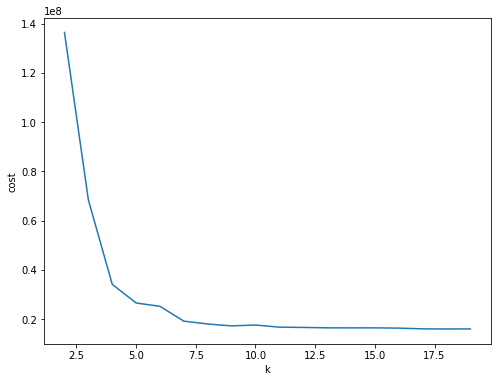

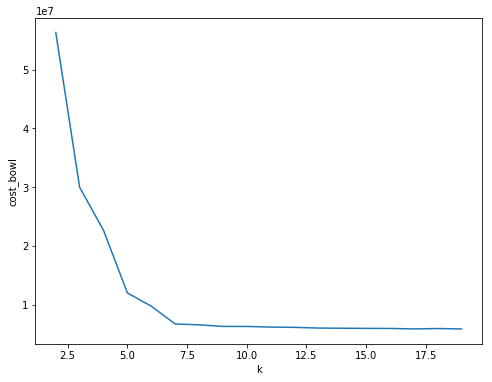

In [7]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost_bowl[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost_bowl')

In [8]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

k = 7
kmeans_bowl = KMeans().setK(k).setSeed(1).setFeaturesCol("features_bowl")
model_bowl = kmeans_bowl.fit(df_kmeans_bowl)
centers_bowl = model_bowl.clusterCenters()

print("Cluster Centers: ")
for center in centers_bowl:
    print(center)


Cluster Centers: 
[ 51.79365079  47.47619048   4.51587302  13.96126986 116.29238098]
[4280.7        3163.7         121.3          35.89699993  136.13399887]
[3177.83333333 2406.5         107.16666667   29.78499985  132.72333272]
[1656.5        1322.75         59.3          28.65249996  125.33500061]
[351.65909091 291.90909091  19.15909091  20.25136369 121.2375008 ]
[1079.53846154  826.57692308   38.80769231   28.98153841  131.08577024]
[2468.18181818 1946.           87.81818182   28.80999999  127.7018176 ]
[160.28985507 135.76811594   9.15942029  19.9053622  120.28449305]
[10.624     16.192      2.152      5.37216   60.8750401]
[672.51851852 515.14814815  29.77777778  23.97703718 131.61740847]
Cluster Centers: 
[395.69072165  13.28865979  47.8329896   33.6718556    8.32896904
  24.15298963]
[3478.4         129.2         455.95999756   27.59199982    7.66999989
   21.67400017]
[2251.92857143   82.85714286  292.14285605   27.81071431    7.7621429
   21.50214304]
[117.5          3.7164179

In [9]:
transformed = model.transform(df_kmeans).select('player_name', 'prediction')
rows = transformed.collect()
print(rows[:3])

transformed = model_bowl.transform(df_kmeans_bowl).select('player_name', 'prediction')
rows_bowl = transformed.collect()
print(rows_bowl[:3])

[Row(player_name='A Ashish Reddy', prediction=4), Row(player_name='A Chopra', prediction=0), Row(player_name='A Choudhary', prediction=0)]
[Row(player_name='A Ashish Reddy', prediction=0), Row(player_name='A Chandila', prediction=3), Row(player_name='A Choudhary', prediction=3)]


In [10]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

df_pred_bowl = sqlContext.createDataFrame(rows_bowl)
df_pred_bowl.show()

+---------------+----------+
|    player_name|prediction|
+---------------+----------+
| A Ashish Reddy|         4|
|       A Chopra|         0|
|    A Choudhary|         0|
|     A Flintoff|         0|
|       A Kumble|         8|
|       A Mishra|         4|
|       A Mithun|         0|
|       A Mukund|         8|
|        A Nehra|         0|
|        A Singh|         8|
|      A Symonds|         5|
|       A Uniyal|         8|
|        A Zampa|         8|
|    AA Bilakhia|         0|
|      AA Chavan|         8|
|AA Jhunjhunwala|         7|
|      AA Noffke|         8|
|     AB Agarkar|         7|
|      AB Barath|         0|
|       AB Dinda|         8|
+---------------+----------+
only showing top 20 rows

+---------------+----------+
|    player_name|prediction|
+---------------+----------+
| A Ashish Reddy|         0|
|     A Chandila|         3|
|    A Choudhary|         3|
|     A Flintoff|         3|
|       A Kumble|         4|
|       A Mishra|         1|
|       A Mithun|

In [12]:
bat_cluster=df_pred.toPandas()
bat_cluster.to_csv("/home/anup/bdProject/bd/batting_cluster.csv")

bowl_cluster=df_pred_bowl.toPandas()
bowl_cluster.to_csv("/home/anup/bdProject/bd/bowling_cluster.csv")


In [13]:
# df_pred = df_pred.join(batting, 'player_name')
# df_pred_bowl = df_pred_bowl.join(bowling, 'player_name')
df_pred.show()
df_pred_bowl.show()


+---------------+----------+
|    player_name|prediction|
+---------------+----------+
| A Ashish Reddy|         4|
|       A Chopra|         0|
|    A Choudhary|         0|
|     A Flintoff|         0|
|       A Kumble|         8|
|       A Mishra|         4|
|       A Mithun|         0|
|       A Mukund|         8|
|        A Nehra|         0|
|        A Singh|         8|
|      A Symonds|         5|
|       A Uniyal|         8|
|        A Zampa|         8|
|    AA Bilakhia|         0|
|      AA Chavan|         8|
|AA Jhunjhunwala|         7|
|      AA Noffke|         8|
|     AB Agarkar|         7|
|      AB Barath|         0|
|       AB Dinda|         8|
+---------------+----------+
only showing top 20 rows

+---------------+----------+
|    player_name|prediction|
+---------------+----------+
| A Ashish Reddy|         0|
|     A Chandila|         3|
|    A Choudhary|         3|
|     A Flintoff|         3|
|       A Kumble|         4|
|       A Mishra|         1|
|       A Mithun|

In [40]:
# pddf_pred = df_pred.toPandas().set_index('player_name')
# pddf_pred.to_csv("/home/gajendra/Documents/Big_Data/Project/stats_batting_prediction.csv")

In [14]:
batting_prob=sqlContext.read.csv("/home/anup/bdProject/bd/r_prob.csv", header=True, mode="DROPMALFORMED")
bowling_prob=sqlContext.read.csv("/home/anup/bdProject/bd/wicket.csv",header=True,mode="DROPMALFORMED")
# batting_prob.show()
# bowling_prob.show()


In [15]:
batting_prob_clus=batting_prob.join(df_pred_bowl,df_pred_bowl.player_name==batting_prob.bowler,'leftouter').select(batting_prob["*"],df_pred_bowl["prediction"])

batting_prob_clus=batting_prob_clus.selectExpr("_c0 as index","batsman as batsman","bowler as bowler","P0 as P0","P1 as P1","P2 as P2","P3 as P3","P4 as P4","P6 as P6","prediction as bowler_cluster")
batting_prob_clus=batting_prob_clus.join(df_pred,df_pred.player_name==batting_prob_clus.batsman,'leftouter').select(batting_prob_clus["*"],df_pred["prediction"])
batting_prob_clus=batting_prob_clus.selectExpr("index as index","batsman as batsman","bowler as bowler","P0 as P0","P1 as P1","P2 as P2","P3 as P3","P4 as P4","P6 as P6","bowler_cluster as bowler_cluster","prediction as batsman_cluster")


bowling_prob_clus=bowling_prob.join(df_pred_bowl,df_pred_bowl.player_name==bowling_prob.bowler,'leftouter').select(bowling_prob["*"],df_pred_bowl["prediction"])
bowling_prob_clus=bowling_prob_clus.selectExpr("_c0 as index","batsman as batsman","bowler as bowler","no_of_times as no_of_times","no_of_balls as no_of_balls","p_out as p_out","p_not_out as p_not_out","prediction as bowler_cluster")
bowling_prob_clus=bowling_prob_clus.join(df_pred,df_pred.player_name==bowling_prob_clus.batsman,'leftouter').select(bowling_prob_clus["*"],df_pred["prediction"])
bowling_prob_clus=bowling_prob_clus.selectExpr("index as index","batsman as batsman","bowler as bowler","no_of_times as no_of_times","no_of_balls as no_of_balls","p_out as p_out","p_not_out as p_not_out","bowler_cluster as bowler_cluster","prediction as batsman_cluster")
batting_prob_clus.show()
# bowling_prob_clus.show()
# pddf_pred = bowling_prob_clus.toPandas()
# pddf_pred1 = bowling_prob.toPandas()
# print(pddf_pred.shape)
# print(pddf_pred1.shape)
# print(pddf_pred)


+-----+-------------+---------------+-----------------+-----------------+-----------------+---+-----------------+-----------------+--------------+---------------+
|index|      batsman|         bowler|               P0|               P1|               P2| P3|               P4|               P6|bowler_cluster|batsman_cluster|
+-----+-------------+---------------+-----------------+-----------------+-----------------+---+-----------------+-----------------+--------------+---------------+
| 7726|Kuldeep Yadav|      S Aravind|                1|                0|                0|  0|                0|                0|             4|              8|
| 7727|Kuldeep Yadav|     TG Southee|              0.2|              0.4|                0|  0|              0.4|                0|             4|              8|
| 7723|Kuldeep Yadav|      HH Pandya|0.333333333333333|0.666666666666667|                0|  0|                0|                0|             4|              8|
| 7728|Kuldeep Yadav| 

In [16]:
pd_bowling_prob=bowling_prob_clus.toPandas()
pd_batting_prob=batting_prob_clus.toPandas()

In [17]:
pd_batting_prob.to_csv("/home/anup/bdProject/bd/pd_batting_prob.csv")
pd_bowling_prob.to_csv("/home/anup/bdProject/bd/pd_bowling_prob.csv")


In [18]:
df=pd.read_csv('/home/anup/bdProject/bd/pd_batting_prob.csv')
df2=pd.read_csv('/home/anup/bdProject/bd/pd_bowling_prob.csv')


In [19]:
#res=df.groupby(['player_out','bowler'])['wicket_kind'].count().reset_index(name='number_of_times')
res = df.groupby(["bowler_cluster","batsman_cluster"])['P0','P1','P2','P3','P4','P6'].mean().round(2).reset_index()
res2 = df2.groupby(["bowler_cluster","batsman_cluster"])['p_not_out'].mean().round(2).reset_index()

In [20]:
ref = df.groupby(["batsman","bowler"])['P0','P1','P2','P3','P4','P6'].mean().round(2).reset_index()
ref2 = df2.groupby(["batsman","bowler"])['p_not_out'].mean().round(2).reset_index()

In [21]:
final_ref=ref
final_ref=final_ref.merge(ref2,how='outer',left_on=["batsman","bowler"],right_on=["batsman","bowler"])

In [22]:
final=res
final['p_not_out']=res2['p_not_out']

In [23]:
final_ref.to_csv('/home/anup/bdProject/bd/pp_prob.csv',index=None)
final.to_csv('/home/anup/bdProject/bd/clusters_prob.csv',index=None)

In [85]:
#--------------------------